In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from matplotlib import image

## Removing outliers and noise with RPCA

In essence, RCPA is a matrix recovery method designed for matricies that are corrupted or have outliers. The application is particularly useful in bioinformatics settings. PCA is thwarted by outliers but RPCA handles them well as long as the matrix has "low intrinsic complexity", or in other words, is "sparse in some basis", has low rank, or "lies in some low-dimensional manifold".
\
\
see papers here: \
https://arxiv.org/pdf/0912.3599.pdf \
https://papers.nips.cc/paper_files/paper/2009/file/c45147dee729311ef5b5c3003946c48f-Paper.pdf

### Image 1: Coffee Stain

(740, 735, 3)


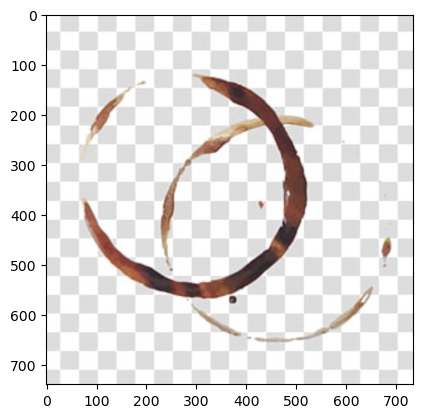

In [2]:
file = r"C:\Users\zacwa\OneDrive\Documents\ML&AI Library\images for practice\coffee stain 2.jpg"
img =  image.imread(file)
m,n,k = img.shape
print(img.shape)
plt.imshow(img)

#### convert to grayscale

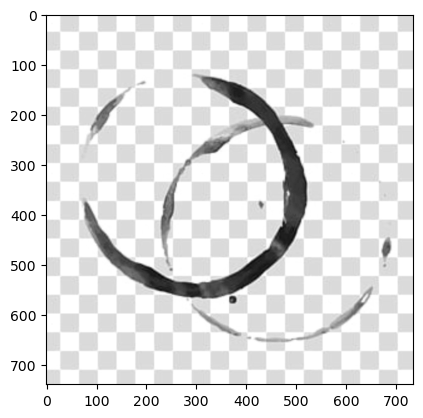

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

imgray = rgb2gray(img)
imgray = (imgray - np.min(imgray))/(np.max(imgray) - np.min(imgray))
plt.imshow(imgray,cmap='gray')

### a: pseudo code

There is a typo below in the archived paper that shows a + instead of a -.

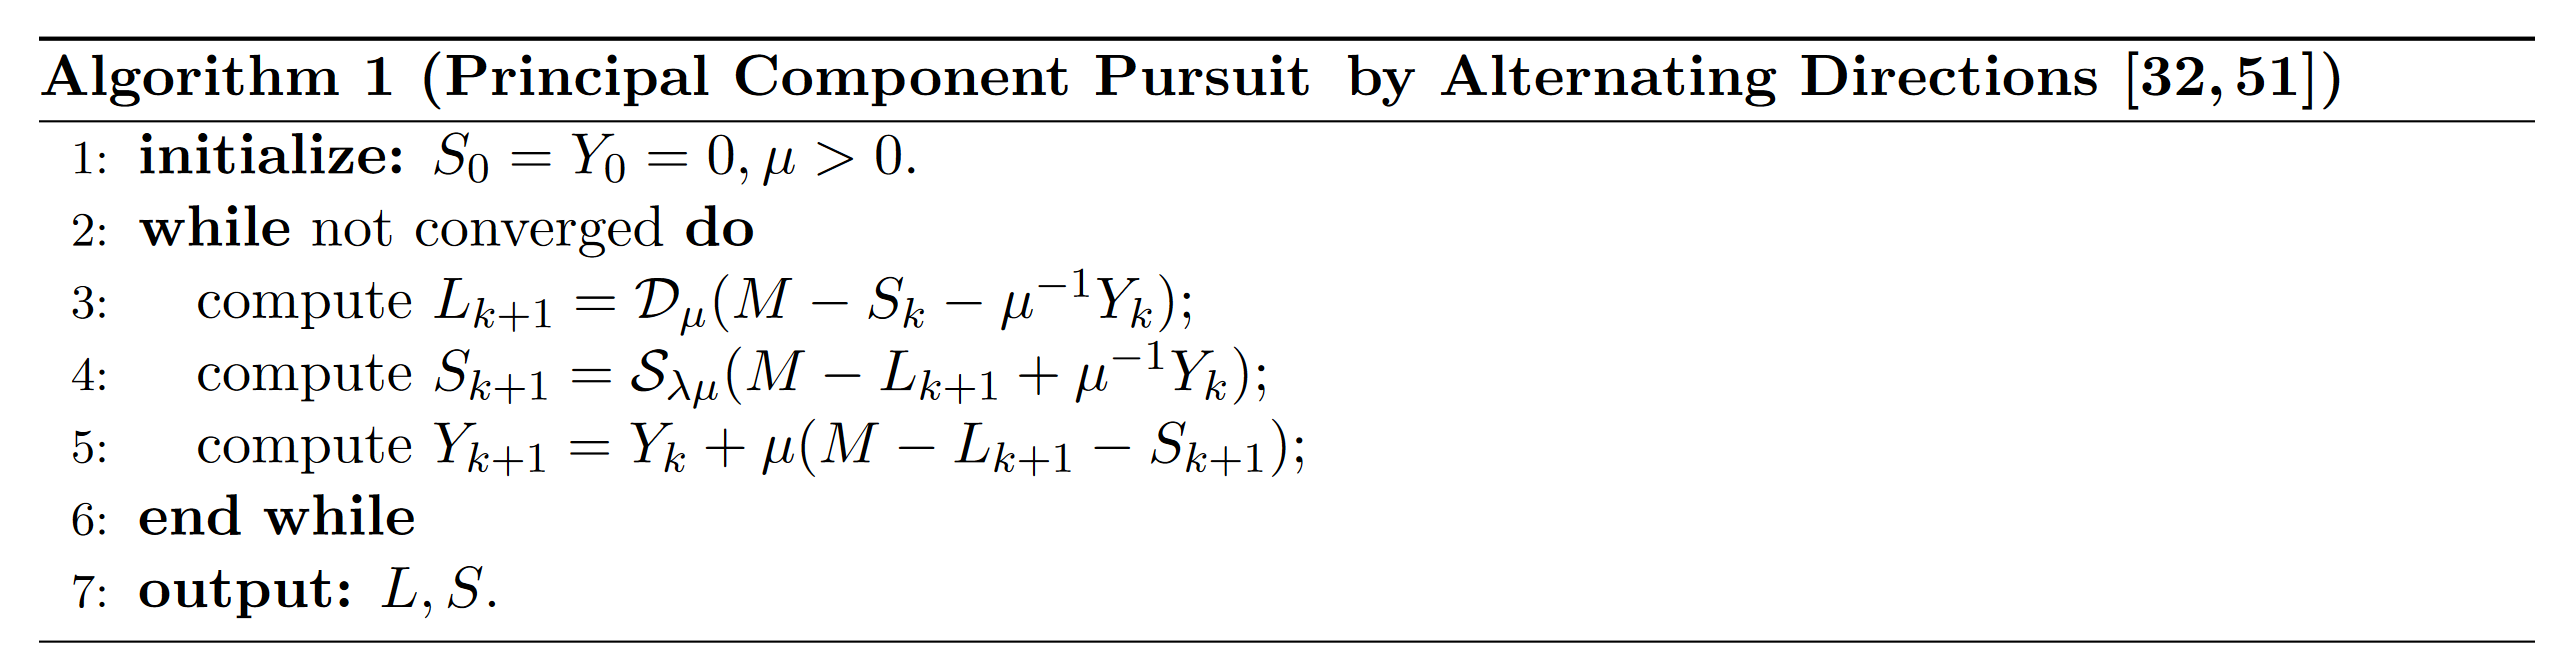

### b: algorithm

In [4]:
def rcpa(imgray,l,m_,d):    
    tol = 1e-3
    maxIter = 700

    lam = l
    M = imgray.copy()
    Y = imgray.copy()
    norm2 = np.linalg.norm(Y, 2)
    normInf = Y.max()/lam
    Y = Y/normInf
    m, n = imgray.shape
    L_hat = np.zeros((m, n))  # Smooth component, L "low rank"
    S_hat = np.zeros_like(L_hat)  # Noise component, S "sparse"
    
    delta = d
    mu = m_
    rho = 1.01
    M_norm = np.linalg.norm(M, 'fro')
    i = 0
    criterion = 1

    while criterion > tol and i < maxIter:
        i += 1

        # soft threshold on scalars for sparsity
        X = M - L_hat + Y/mu
        lst = lam/mu # threshold
        S_hat = np.sign(X)*np.maximum(np.abs(X)-lst, 0)

        # soft threshold SVD for low rank
        st = delta/mu
        u, s, vh = np.linalg.svd(M-S_hat+Y/mu,full_matrices=False)
        sno = (s > st).sum() # threshold for singulars
        L_hat = u[:, :sno]@( np.diag((s[:sno]-st)) )@vh[:sno] # reconstruct

        Z = M - L_hat - S_hat  # constraint violation
        Y = Y + mu*Z  # update lagragian multipliers
        mu = mu*rho # gradually increases mu

        # converges when distance of Z is negligible
        # . . . when L + S account for M
        criterion = np.linalg.norm(Z, 'fro') / M_norm

    fig, axs = plt.subplots(1,2,figsize=(10,10))
    axs = axs.flatten()
    axs[0].imshow(L_hat,cmap='gray')
    axs[0].set_title(f'lam {lam}, mu {mu}')
    axs[1].imshow(S_hat,cmap='gray')
    plt.show()
    
    return L_hat, S_hat

In [5]:
def rcpa_viz(L_hat,S_hat): 
    # # # plots
    fi, axs = plt.subplots(2,2,figsize=(10,10))

    axs[0,0].imshow(imgray,cmap='gray')
    axs[0,0].set_title('Original Image: L + S')

    axs[0,1].imshow(L_hat, cmap='gray')
    axs[0,1].set_title("L Matrix: Low Rank Smooth Component")

    E_hat = np.clip(S_hat, 0, 255)
    axs[1,0].imshow(S_hat, cmap='gray')
    axs[1,0].set_title("S+E Matrix: Sparse Noise Component")

    axs[1,1].imshow(S_hat+L_hat, cmap='gray')
    axs[1,1].set_title("Reconstructed M Matrix")

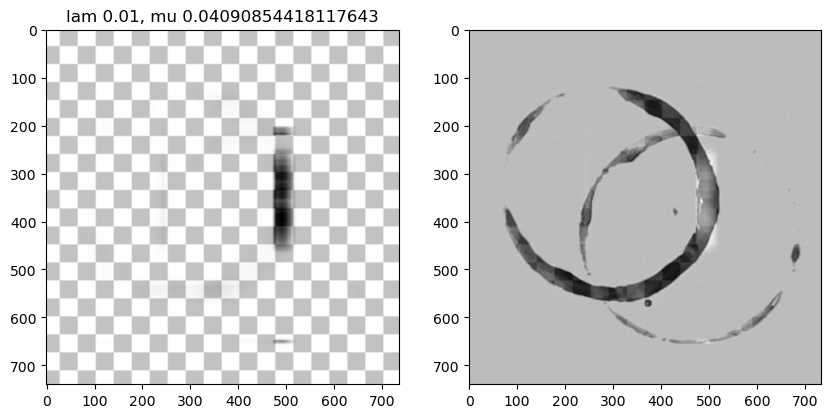

In [6]:
L, S = rcpa(imgray,l=0.01,m_=0.011,d=1)

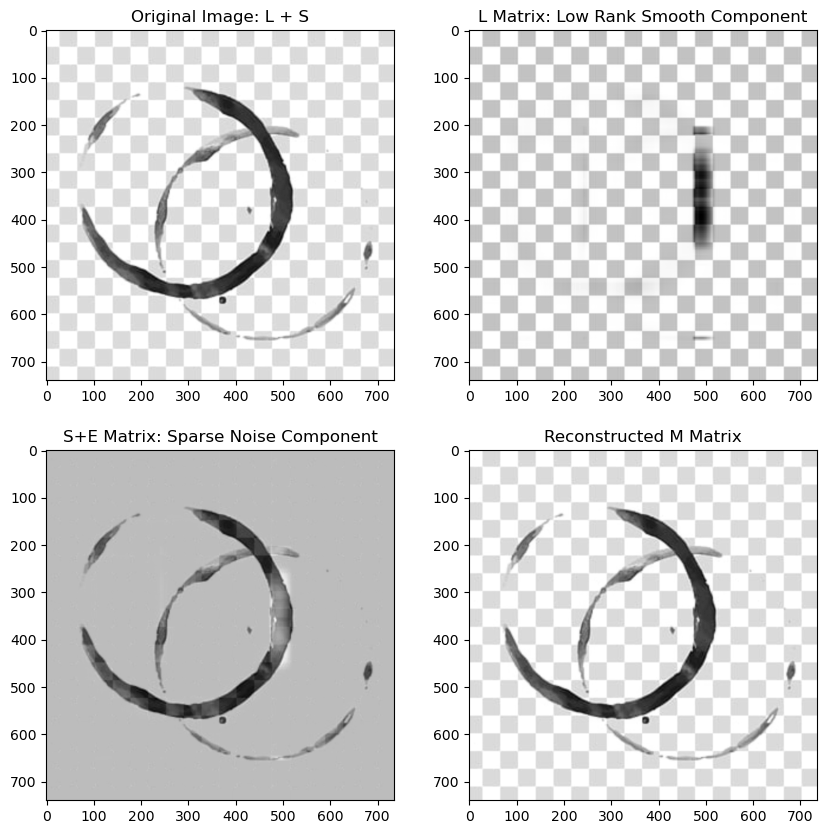

In [7]:
rcpa_viz(L,S)

### c. algorithm on gaussian noise

#### add gaussian noise

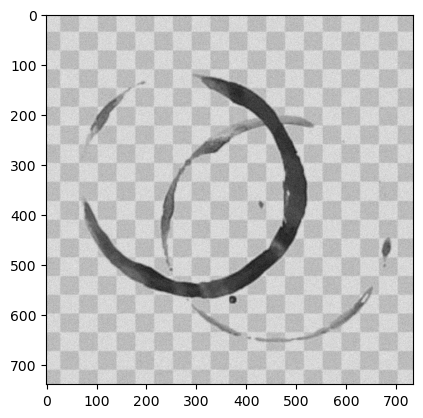

In [8]:
imgnoise = imgray + np.random.normal(0,0.05,(m,n))
plt.imshow(imgnoise,cmap='gray')

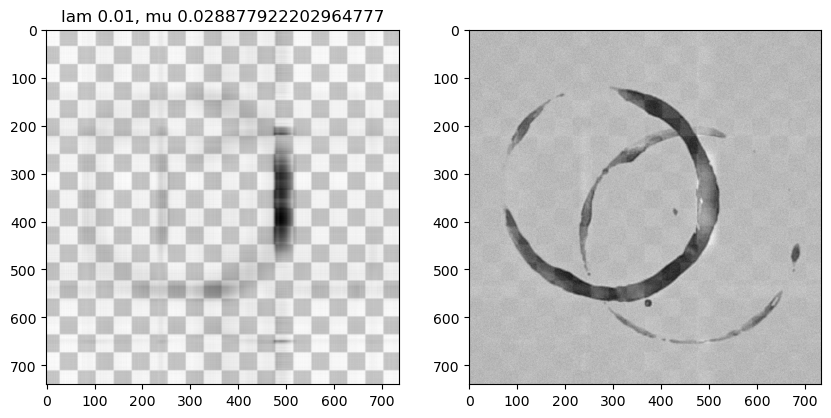

In [9]:
Ln, Sn = rcpa(imgnoise,l=0.01,m_=0.011,d=1)

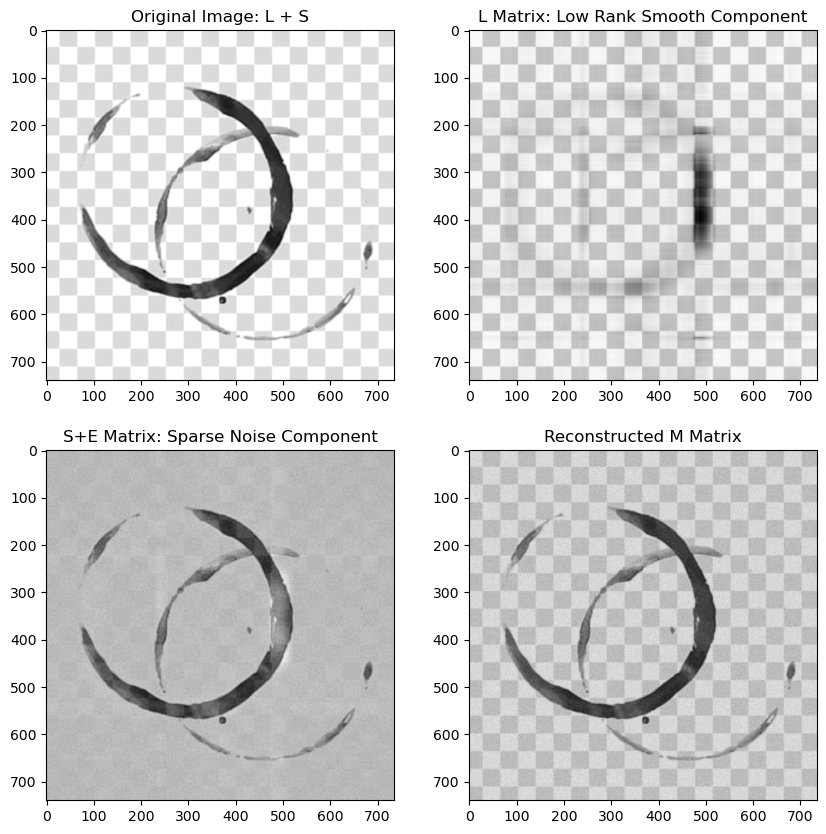

In [10]:
rcpa_viz(Ln,Sn)

### Image 2: Floral Pattern

In [12]:
def import_gray(file):
    img =  image.imread(file)
    m,n,k = img.shape
    print('shape:',img.shape)
    
    # # # grayscale
    imgray = rgb2gray(img)
    imgray = (imgray - np.min(imgray))/(np.max(imgray) - np.min(imgray))
    
    fig, ax = plt.subplots(1,2,figsize=(10,10))
    ax = ax.flatten()
    ax[0].imshow(img,cmap='gray')
    ax[1].imshow(imgray,cmap='gray')
    plt.show()
    return imgray

shape: (652, 645, 3)


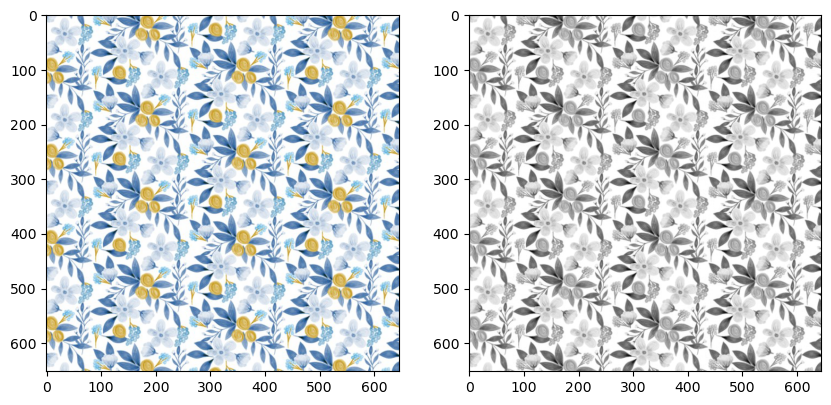

In [13]:
file = r"C:\Users\zacwa\OneDrive\Documents\ML&AI Library\images for practice\floral 1.jpg"
floral1 = import_gray(file)

Adding some outliers to the image

In [14]:
def add_outliers(img):

    a = np.mean(img)
    std = np.std(img)
    # number of outliers
    nouts = np.random.randint(10,20)

    for no in range(nouts):
        # starting index of outlier
        si = np.random.randint(100,600)
        sj = np.random.randint(100,600)
        # outlier size 
        h = np.random.randint(10,30)
        w = np.random.randint(10,30)
        img[si:si+h,sj:sj+w] = 0
        
    return img

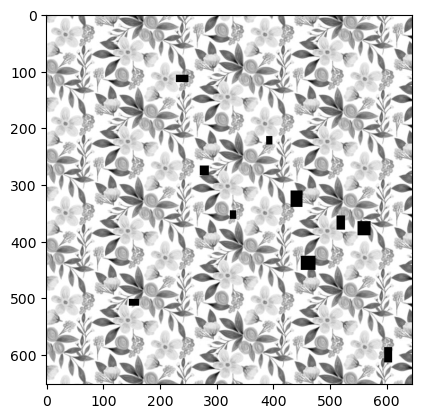

In [15]:
f1_outliers = add_outliers(floral1.copy())
plt.imshow(f1_outliers,cmap='gray')

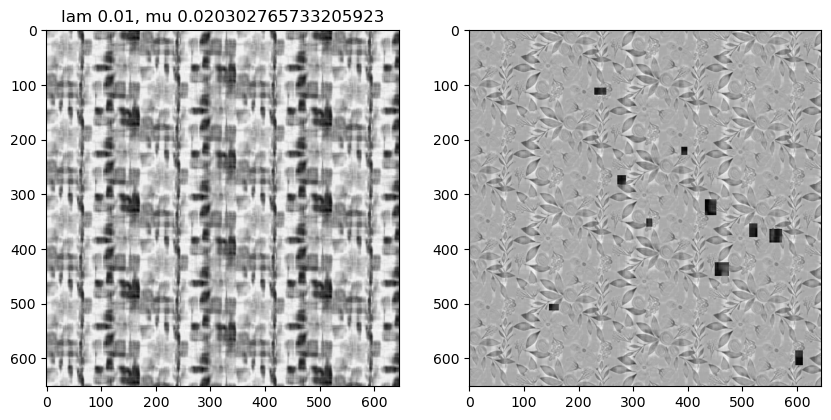

In [16]:
L4, S4 = rcpa(f1_outliers,l=0.01,m_=0.0011,d=1)

### Image 3: Tablecloth

shape: (637, 960, 3)


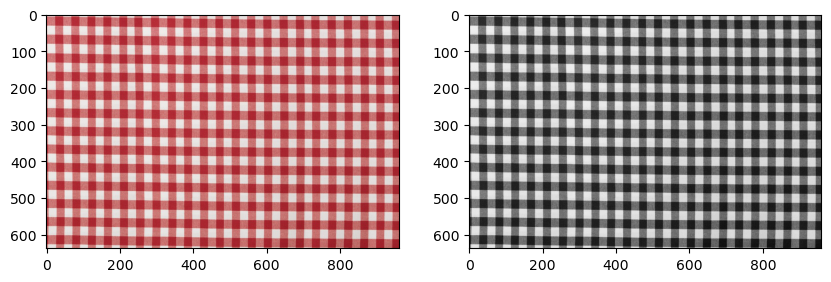

In [17]:
file = r"C:\Users\zacwa\OneDrive\Documents\ML&AI Library\images for practice\tablecloth.jpg"
table = import_gray(file)

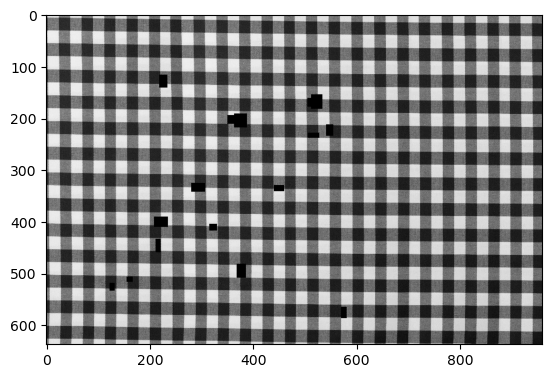

In [18]:
table_outliers = add_outliers(table.copy())
plt.imshow(table_outliers,cmap='gray')

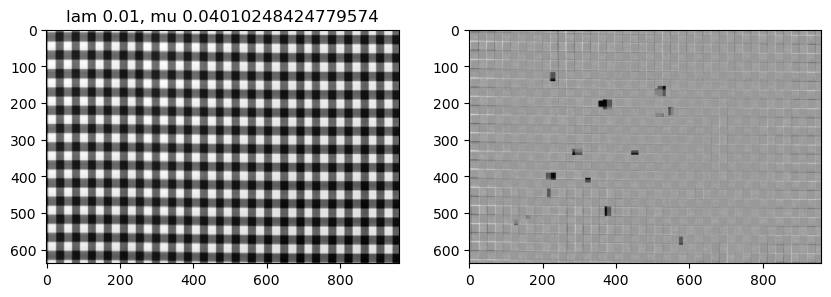

In [19]:
L5, S5 = rcpa(table_outliers,l=0.01,m_=0.011,d=1)